In [95]:
import pandas as pd

party_replace = {
    'PARTI KEADILAN RAKYAT (PKR)': 'PAKATAN HARAPAN (PH)',
    'PARTI TINDAKAN DEMOKRATIK (DAP)': 'PAKATAN HARAPAN (PH)',
    'PARTI ISLAM SE MALAYSIA (PAS)': 'PERIKATAN NASIONAL (PN)',
    'IKATAN DEMOKRATIK MALAYSIA (MUDA)': 'PAKATAN HARAPAN (PH)'
}

df = pd.read_csv('data/candidates_ge15.csv',usecols=['state','parlimen','party','name','result'])
df.party = df.party.replace(party_replace).fillna(df.party)
df = df[df.result == 1].drop('result',axis=1)
n_seats = df[['party']].groupby('party').size()
df = df[~df.state.isin(['Sabah','Sarawak','W.P. Labuan'])] # to add East Msia, comment out this line
df.party = df.party.map(party_replace).fillna(df.party)
df['party_short'] = df.party.str.extract(r'\((\w+)\)')
party_abbr = dict(zip(df.party,df.party_short))
df = df.drop('party_short',axis=1)

var_demog = 'ethnicity_proportion_bumi' # change at will - there's quite a bit of stuff in the census data
ef = pd.read_csv('data/census_parlimen.csv',usecols=['state','parlimen',var_demog])

df = pd.merge(df,ef,on=['state','parlimen'],how='left')
assert len(df[df[var_demog].isnull()]) == 0, 'Missing data!' # ensure complete merge
demog_mean = (df[['party',var_demog]].groupby('party').mean()).to_dict()
df = df.sort_values(by=var_demog).reset_index(drop=True)
df['plot'] = 1
df

,state,parlimen,name,party,ethnicity_proportion_bumi,plot
0,Pulau Pinang,P.049 Tanjong,Lim Hui Ying,PAKATAN HARAPAN (PH),16.926889,1
1,Pulau Pinang,P.048 Bukit Bendera,Syerleena Binti Abdul Rashid,PAKATAN HARAPAN (PH),17.880855,1
2,W.P. Kuala Lumpur,P.114 Kepong,Lim Lip Eng,PAKATAN HARAPAN (PH),20.173528,1
3,Pulau Pinang,P.043 Bagan,Lim Guan Eng,PAKATAN HARAPAN (PH),21.634648,1
4,Pulau Pinang,P.051 Bukit Gelugor,Ramkarpal Singh A/L Karpal Singh,PAKATAN HARAPAN (PH),22.476038,1
...,...,...,...,...,...,...
160,Kelantan,P.025 Bachok,Mohd Syahir Bin Che Sulaiman,PERIKATAN NASIONAL (PN),98.789470,1
161,Kelantan,P.028 Pasir Puteh,Nik Muhammad Zawawi Bin Salleh,PERIKATAN NASIONAL (PN),98.875980,1
162,Kelantan,P.030 Jeli,Zahari Bin Kechik,PERIKATAN NASIONAL (PN),99.373350,1
163,Terengganu,P.038 Hulu Terengganu,Rosol Bin Wahid,PERIKATAN NASIONAL (PN),99.493316,1


PH is coloured in red, with 82 seats which are 51.4% Bumiputera on average.
PN is coloured in grey, with 74 seats which are 87.8% Bumiputera on average.
BN is coloured in blue, with 30 seats which are 76.8% Bumiputera on average.


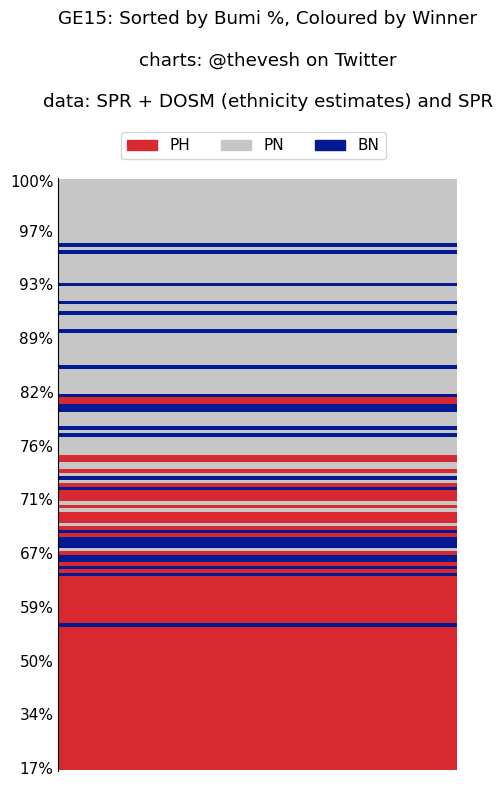

In [96]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as tkr
import numpy as np


party_color = { # colors from SPR dashboard
    'PAKATAN HARAPAN (PH)':'#d7292f',
    'PERIKATAN NASIONAL (PN)':'#c6c6c6', # to ensure no red-green colour-blind clash
    'BARISAN NASIONAL (BN)':'#031a93',
    'GABUNGAN PARTI SARAWAK (GPS)': '#1f2c45',
    'PARTI GABUNGAN RAKYAT SABAH (GRS)': '#5bc5f0',
    'PARTI WARISAN SABAH (WARISAN)': '#5bc5f0',
    'BEBAS (BEBAS)': '#000000', 
    'PARTI KESEJAHTERAAN DEMOKRATIK MASYARAKAT (KDM)': '#000000',
    'PARTI BANGSA MALAYSIA (PBM)': '#000000'
}

party_color_desc = { # colors from SPR dashboard
    'PAKATAN HARAPAN (PH)':'red',
    'PERIKATAN NASIONAL (PN)':'grey', # to ensure no red-green colour-blind clash
    'BARISAN NASIONAL (BN)':'blue',
    'GABUNGAN PARTI SARAWAK (GPS)': 'dark greyish blue',
    'PARTI GABUNGAN RAKYAT SABAH (GRS)': 'light blue',
    'PARTI WARISAN SABAH (WARISAN)': 'light blue',
    'BEBAS (BEBAS)': 'black', 
    'PARTI KESEJAHTERAAN DEMOKRATIK MASYARAKAT (KDM)': 'black',
    'PARTI BANGSA MALAYSIA (PBM)': 'black'
}

n_parties = 3
df['color'] = df.party.map(party_color)
selected_parties = list(party_color.keys())[:n_parties]

plt.rcParams.update({'font.size': 11,
                     'font.family': 'sans-serif',
                     'grid.linestyle': 'dashed'})
plt.rcParams["figure.figsize"] = [5,8]
plt.rcParams["figure.autolayout"] = True
fig, ax = plt.subplots()

y_labels = df[df.party.isin(selected_parties)][var_demog].tolist()
y_labels_keep = [0+15*x for x in range(11)] + [164]
def filter_label(str, i): return str if i in y_labels_keep else ''
y_labels = [filter_label(f'{np.round(y_labels[i],0):,.0f}%', i) for i in range(len(y_labels))]

df[df.party.isin(selected_parties)].plot(kind='barh', width=1, y='plot', edgecolor='black', lw=0,
                color=df[df.party.isin(selected_parties)].color.tolist(), ax=ax, legend=False)
ax.set_title(f'GE15: Sorted by Bumi %, Coloured by Winner\n\ncharts: @thevesh on Twitter\n\ndata: SPR + DOSM (ethnicity estimates) and SPR\n\n\n')
for p in ['top','bottom','right']: ax.spines[p].set_visible(False)
ax.set_yticklabels(y_labels)
ax.set_ylabel('')
ax.axes.get_xaxis().set_visible(False)
ax.set_axisbelow(True)
ax.tick_params(length=0)


patches = [mpatches.Patch(color=party_color[p], label=f'{party_abbr[p]}') for p in selected_parties]
ax.legend(handles=patches,labelspacing = 1.5, ncol=3, bbox_to_anchor=(0.8,1.09))

# ALT text
for p in list(party_color.keys())[:n_parties]: 
    print(f"""\
{p[-3:-1]} is coloured in {party_color_desc[p]}, \
with {n_seats[p]} seats which are {demog_mean[var_demog][p]:,.1f}% Bumiputera on average.\
""")